<H1>Redes Neuronales - TP1 (1c2019)</H1>

<H5>Adrián Castiglione (lu 818/15)</H5>

Este trabajo consta de 2 ejercicios en los que se búsca resolver un problema utilizando redes neuronales artificiales feedforward. En ambos ejercicios se utilizarán perceptrones simples o multicapa según se crea conveniente para el problema en cuestión. 
Los perceptrones fueron desarrollados para este trabajo, sin embargo para el procesamiento y visualización de datos y evaluación de modelos se utilizarán librerías externas.

    
  

In [44]:
#PREAMBULOS

%matplotlib inline
from IPython.display import display, HTML

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn import model_selection

from multilayerperceptron import MultilayerPerceptron
from perceptron import Perceptron


<H3> Ejercicio 1 - Detección de cancer de mama </H3>

Para este ejercicio se cuenta con una serie de datos de diferentes pacientes. Para cada uno de ellos se cuenta con los resultados de un estudio en particular de cancer de mama junto con el diagnóstico del mismo (Benigno, simbolizado con la letra B, y maligno, simbolizado con la letra M). Se busca crear un modelo de red neuronal que pueda identificar correctamente el tipo de cancer. Para ello se iniciará con una exploración de los datos.

In [52]:
# Carga de datos
index= ['diagnostico', 'radio', 'textura', 'perimetro', 'area', 'suavidad', 
        'compacidad', 'concavidad', 'puntos_concavos', 'simetria', 'densidad']

data_file = "tp1_ej1_training.csv"

all_data = pd.read_csv(data_file, names=index)
X = all_data.copy(True)

y = X[["diagnostico"]]
del X["diagnostico"]

y = y.replace('M', 1).replace('B', 0)

display(X.head())
display(y.head())



,radio,textura,perimetro,area,suavidad,compacidad,concavidad,puntos_concavos,simetria,densidad
0,11.779,29.321,93.649,1300.312,2.469,1.071,4.459,6.299,0.586,1.506
1,18.631,16.772,126.232,657.973,1.659,1.230,4.179,5.549,0.678,1.734
2,11.221,29.886,120.610,1302.758,2.519,2.485,5.281,6.633,0.748,1.999
3,14.418,29.200,101.041,1384.419,2.519,1.545,3.802,4.359,0.527,1.778
4,20.089,27.558,99.301,917.233,2.107,1.986,2.447,1.845,0.693,1.499


,diagnostico
0,1
1,0
2,0
3,1
4,0


Este es un problema de clasificación cuyas clases son Maligno y Benigno, codificadas con el 1 y el 0 respectivamente. En cuanto a los datos, se encuentran en diferentes escalas y esto podría derivar en problemas a la hora de entrenr la red neuronal. Por este motivo se procederá a normalizar cada una de las columnas al rango [0,1]

In [53]:
#Data scaling (normalization with min max, fitting range [0,1] for each feature)
data = X.values
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data = min_max_scaler.fit_transform(data)
X = pd.DataFrame(scaled_data, columns = X.columns)
display(X.head())

,radio,textura,perimetro,area,suavidad,compacidad,concavidad,puntos_concavos,simetria,densidad
0,0.227081,0.813734,0.344544,0.490694,0.587835,0.231237,0.588098,0.692011,0.400668,0.497948
1,0.551375,0.293029,0.569705,0.218228,0.390754,0.284990,0.547258,0.606900,0.477462,0.575923
2,0.200672,0.837178,0.530855,0.491732,0.600000,0.709263,0.707993,0.729914,0.535893,0.666553
3,0.351981,0.808714,0.395626,0.526371,0.600000,0.391481,0.492270,0.471857,0.351419,0.590971
4,0.620380,0.740581,0.383602,0.328201,0.499757,0.540568,0.294632,0.186564,0.489983,0.495554


Para entrenar y evaluar la red neuronal se separarán los datos. El 80% de los mismos se utilizarán para el entrenamiento de la red, 10% de los mismos se utilizarán para testear la misma. El proceso de entrenamiento y testeo se utilizará para diferentes modelos, luego se seleccionará el mejor de ellos y se evaluará con el 10% de datos restante. 

In [54]:
X_learning, X_eval, y_learning, y_eval = sklearn.model_selection.train_test_split(
    X, y, random_state=1234, test_size=0.2)

X_test, X_val, y_test, y_eval = sklearn.model_selection.train_test_split(
    X_eval, y_eval, random_state=5678, test_size=0.5)

display(X_learning.shape)
display(X_test.shape)
display(X_val.shape)


(328, 10)

(41, 10)

(41, 10)

El modelo usado combinará un perceptrón multicapa que estimará la probabilidad de ocurrencia de cada clase (tumor maligno o benigno). Luego, a partir de esas probabilidades un perceptrón simple decidirá cual será la clase predecida a partir de los datos. La idea es no utilizar un umbral de decisión arbitrario sino que sea el propio modelo el que lo encuentre a partir del aprendizaje.

Se búsca probar diferentes modelos a partir de la combinación de diferentes hiperparámetros, para eso se utilizará la libreria scikit-learn. Es necesario entonces cumplir con la interfaz de un estimador de esta libreria para poder usar el modelo en conjunto con ella. 
En escencia la interfaz requiere: 
1) Extender el BaseEstimator de la librería
2) Proponer valores default para todos los parametros de la inicialización, de manera que pueda realizarse inicialización default del estimador
3) Todos los parametros del inicializador deben guardarse en la instancia del estimador con los mismos nombres
4) Se deben proveer los métodos fit y predict, ambos aceptando arreglos X e y correspondientes a las instancias con su correcta clasificación.
5) Opcionalmente se debe proveer un scorer (medida de performance). Si no se hace se debe proveer más adelante al evaluar el modelo (esto último es lo que se hará en este trabajo).

El modelo para este ejercicio toma las respuestas de salida (de dimensión 1), considerando 1 como Maligno y 0 como benigno, y lo transforma en una salida de dimensión 2, donde una instancia de Maligno será (1, 0) indicando que es 100% tumor Maligno y 0% tumor Benigno. Análogamente, una instancia de Benigno será (0, 1) con la misma interpretación. 
Una vez transformados los datos se entrenará el perceptrón multicapa. Luego, las salidas de este perceptrón servirán como entrada del perceptrón simple, que se entrenará contra las respuestas de salida originales de dimensión 1.

In [45]:
#interface with scikit-learn
from sklearn.base import BaseEstimator
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report

class MlpClassifier(BaseEstimator):
    
    def __init__(self, output_layer_activation = "sigmoid", learning_rate = 1., adaptative_learning_rate = None, momentum = .0, epochs = 500,
                 hidden_layers = []):
        
        self.output_layer_activation = output_layer_activation
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self.adaptative_learning_rate = adaptative_learning_rate
        
        self.hidden_layers = hidden_layers
    
        self._functions_to_remove = []
        self._functions_to_add = []
    
    def fit(self, X, y):
        
        y = np.atleast_1d(y)
        y_not_class = np.array([[1] for x in range(0, len(y))])
        self.y_multi = np.column_stack((y, y_not_class - y))
        
        y_multi = self.y_multi

        self.model = MultilayerPerceptron(self.output_layer_activation, self.hidden_layers)
        self.output_model = Perceptron(2, 1, "step")
                 
        for f in self._functions_to_remove:
            try:
                m.model.remove_activation_function(f)
            except:
                pass
        
        for (name, f, df) in self._functions_to_add:
            m.model.add_activation_function(name, f, df)
        
        self.model.fit(X, y_multi, learning_rate = self.learning_rate, momentum = self.momentum, 
                       epochs = self.epochs, adaptative_learning_rate = self.adaptative_learning_rate)    
        y_probas = self.model.predict(X)
        self.output_model.fit(y_probas, y, epochs = 200, eta=0.1)
        
        return self
    
    def predict(self, X, y = None):
        y_probas = self.model.predict(X)
        return self.output_model.predict(y_probas)
        
    def remove_activation_function(self, name):
        self._functions_to_remove.append(name)
        
    def add_activation_function(self, name, f, df):
        self._functions_to_add.append((name, f, df))

Para buscar el mejor modelo se iniciará con un grid search combinando diferentes hiperparámetros. Dado que, como regla práctica, una sola capa oculta suele ser suficiente para la mayoría de los problemas, sólo se testearan modelos con esta característica.
Otras dos reglas prácticas es que la cantidad optima de neuronas suele estar entre la cantidad de neuronas de las capas de entrada y salida (10 y 2 en este caso), y que muchas veces está alrededor de 2/3 de la dimensión de la capa de entrada mas la dimesión de la capa de salida (ver Introduction to Neural Networks for Java de Jeff Heaton)
Teniendo en cuenta esto se probarán capas ocultas con 5 a 8 neuronas.
En cuanto a las funciones de activación, se utilizarán sigmoideas con beta 0.5 (la que más suele aparecer en libros y aplicaciones) y beta 2 (para acelerar la convergencia o la selección de probabilidad según la capa en la que esté).
Dado que a priori no se tiene noción de los learning rates y epocas necesarias para la convergencia de los modelos, se utilizarán 1000 epocas con learning rate adaptativo (sumando 0.01 en caso de error decreciente o reduciendo 5% el mismo en caso de error creciente) inicializado en 0.1 y un pequeño momentum de 0.01 para reducir la posibilidad de convergencia a mínimos locales.
En cuanto a las métricas utilizadas, se observará el accuracy como una medida general de la performance del modelo. Sin embargo, como se intentan identificar casos de canceres malignos es imperativo reducir la cantidad de falsos negativos del modelo, motivo por el cual se incluirán también las métricas de recall (para observar este último punto) y f2 score (para verificar el compromiso entre recall y precition, haciendo foco en el recall).

In [18]:
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, recall_score

def GridSearch(model, tuned_parameters, scores, X_learning, y_learning, X_test, y_test):

    NAME = 0
    FUNCTION = 1
    
    best_scores = {score[NAME]: 0.0 for score in scores}
    best_models = {score[NAME]: None for score in scores}
    obteined_scores = {score[NAME]: [] for score in scores} 
    
    
    for g in ParameterGrid(tuned_parameters):
        model.set_params(**g)
        print("")
        print("==================================")
        print("training model for paramenters %s" % g)
        print("")
        model.fit(X_learning, y_learning)
        for score in scores:
            current_score = score[FUNCTION](model, X_test, y_test)
            print( "{0} {1} for {2}\n".format(score[NAME], current_score, str(g)) )
            print("")

            obteined_scores[score[NAME]].append((current_score, g))
            
            if current_score > best_scores[score[NAME]]:
                best_scores[score[NAME]] = current_score
                best_models[score[NAME]] = g

    return obteined_scores, best_scores, best_models
    

tunned_parameters = {
    "output_layer_activation" : ["sigmoid", "sigmoidB2"],
    "learning_rate" : [0.1],
    "momentum" : [0.01],
    "epochs" : [1000],
    "adaptative_learning_rate": [(0.01, 0.05)],
    "hidden_layers": [[(x, y)] for x in range(5, 9) for y in ["sigmoid", "sigmoidB2"]]
}

m = MlpClassifier()
m.remove_activation_function("sigmoidB2")
m.add_activation_function("sigmoidB2", (lambda t : 1/(1 + np.exp(-4*t))), (lambda h, v: 4*v*(1-v)))

f2_score = make_scorer(fbeta_score, beta=2)
acc_score = lambda m, X, y: accuracy_score(y, m.predict(X))
rec_score = lambda m, X, y: recall_score(y, m.predict(X))

scores = [("accuracy score", acc_score), ("recall score", rec_score), ("F2 score", f2_score)]
model_results, best_scores, best_models = GridSearch(m, tunned_parameters, scores, X_learning.values, y_learning.values, X_test.values, y_test.values)




training model for paramenters {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(5, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}

accuracy score 0.7804878048780488 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(5, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}


recall score 0.7916666666666666 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(5, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}


F2 score 0.7983193277310924 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(5, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}



training model for paramenters {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(5, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, '

accuracy score 0.8780487804878049 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(7, 'sigmoidB2')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}


recall score 1.0 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(7, 'sigmoidB2')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}


F2 score 0.9600000000000002 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(7, 'sigmoidB2')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}



training model for paramenters {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(7, 'sigmoidB2')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoidB2'}

accuracy score 0.6341463414634146 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(7, 'sigmoidB2')], 'learning_rate': 0.1, 'momentum': 0.01

El modelo que mejor y más estable rendimiento tiene es el dado por la inicialización 
{'adaptative_learning_rate': (0.01, 0.05), 
'epochs': 1000, 
'hidden_layers': [(7, 'sigmoid')], 
'learning_rate': 0.1, 
'momentum': 0.01, 
'output_layer_activation': 'sigmoid'}

Es decir, una red neuronal de una capa oculta de 7 neuronas activadas por la función sigmoidea con beta 0.5. En la capa de salida se mantiene la misma función de activación. Se procederá entonces a evaluar un poco más en detalle este modelo, específicamente cómo evolucionan las métricas a medida que las épocas de entrenamiento aumentan (de 100 a 1000, con pasos de 50). El objetivo es encontrar un punto óptimo que permita un buen entrenamiento de la red sin llegar al overfitting,

In [27]:

def evaluate_model(model, X, y, X_test, y_test, epochs = None):
    
    if epochs is None:
        epochs = list(range(50, 501, 50))
        
    f2_scores_learn = []
    acc_scores_learn = []
    rec_scores_learn = []
    
    f2_scores_test = []
    acc_scores_test = []
    rec_scores_test = []
    
    for current_epochs in epochs:
        model.epochs = current_epochs
        model.fit(X, y)
        
        #learn
        y_pred = model.predict(X)
        f2 = f2_score(m, X, y)
        acc = accuracy_score(y, y_pred)
        rec = recall_score(y, y_pred)
            
        f2_scores_learn.append(f2)
        acc_scores_learn.append(acc)
        rec_scores_learn.append(rec)
        
        #test
        y_pred = model.predict(X_test)
        f2 = f2_score(m, X_test, y_test)
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
            
        f2_scores_test.append(f2)
        acc_scores_test.append(acc)
        rec_scores_test.append(rec)

    return acc_scores_learn, rec_scores_learn, f2_scores_learn, acc_scores_test, rec_scores_test, f2_scores_test, epochs


model = MlpClassifier(hidden_layers=[(7, "sigmoid")], output_layer_activation= "sigmoid", momentum = 0.01,
                     epochs = 1000, learning_rate = 0.1, adaptative_learning_rate = (0.01, 0.05))

acc_scores_learn, rec_scores_learn, f2_scores_learn, \
    acc_scores_test, rec_scores_test, f2_scores_test, epochs = evaluate_model(model, 
                                                                        X_learning.values, y_learning.values, 
                                                                        X_test.values, y_test.values,
                                                                            list(range(100, 1001, 50)))

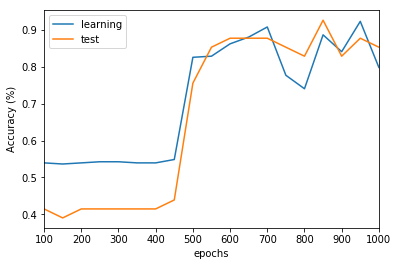

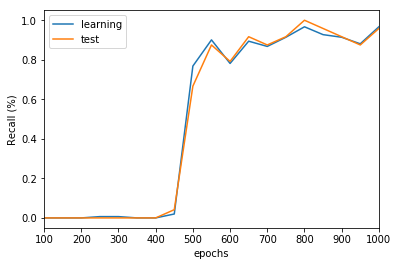

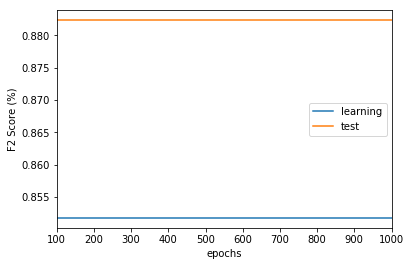

In [31]:
acc_data = pd.DataFrame({'learning' : acc_scores_learn, 'test': acc_scores_test}, index=epochs)
ax = acc_data.plot()
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("epochs")
plt.show()

rec_data = pd.DataFrame({'learning' : rec_scores_learn, 'test': rec_scores_test}, index=epochs)
ax = rec_data.plot()
ax.set_ylabel("Recall (%)")
ax.set_xlabel("epochs")
plt.show()

f2_data = pd.DataFrame({'learning' : f2_scores_learn, 'test' : f2_scores_test}, index=epochs)
ax = f2_data.plot()
ax.set_ylabel("F2 Score (%)")
ax.set_xlabel("epochs")
plt.show()

Una cantidad de épocas de 700 parece ser un número adecuado para entrenar esta red, dado que más alla de ese número comienzan a verse signos de overfitting, sobre todo en el accuracy. Por último se reentrena este modelo con todos los datos disponible y se lo evalua con el 10% de datos correspondientes a validación.

In [60]:
X_final = pd.concat([X_learning, X_test])
y_final = pd.concat([y_learning, y_test])

final_model = MlpClassifier(hidden_layers=[(7, "sigmoid")], output_layer_activation= "sigmoid", momentum = 0.01,
                     epochs = 700, learning_rate = 0.1, adaptative_learning_rate = (0.01, 0.05))

X_final_np = X_final.values
y_final_np = y_final.values
X_val_np = X_val.values
y_val_np = y_eval.values

final_model.fit(X_final_np, y_final_np)
y_pred = final_model.predict(X_val_np)

display("Accuracy: %s" % accuracy_score(y_val_np, y_pred))
display("Recall: %s" % recall_score(y_val_np, y_pred))
display("F2 Score: %s" % f2_score(final_model, X_val_np, y_val_np))


'Accuracy: 0.8536585365853658'

'Recall: 0.9'

'F2 Score: 0.8823529411764706'

<H3> Ejercicios 2 - Eficiencia Energética </H3>

Se busca, dadas ciertas características de distintos edificios, determinar la cantidad de carga energética necesaria para calefaccionar y refrigerar cada uno de ellos. La solución de este problema tendrá una metodología paredida al anterior: se explorarán los datos, se construirá un modelo y se lo testeará. Para ellos los datos se separará tambien en 80% para aprendizaje, 10% para testeo y 10% para validación.

In [73]:
# Carga de datos
index= ['compacidad relativa', 'area superficie total', 'area paredes', 'area techo', 
        'altura total', 'orientacion', 'area reflejo total', 'distribucion area reflejo',
        'carga calefaccion', 'carga refrigeracion']

data_file = "tp1_ej2_training.csv"

all_data_ej2 = pd.read_csv(data_file, names=index)
Xt = all_data_ej2.copy(True)

display(Xt.head())



,compacidad relativa,area superficie total,area paredes,area techo,altura total,orientacion,area reflejo total,distribucion area reflejo,carga calefaccion,carga refrigeracion
0,0.71,710.5,269.5,220.5,3.5,5,0.10,1,10.75,14.27
1,0.79,637.0,343.0,147.0,7.0,5,0.25,2,38.98,45.97
2,0.66,759.5,318.5,220.5,3.5,3,0.10,1,11.69,13.72
3,0.62,808.5,367.5,220.5,3.5,2,0.40,5,16.54,16.88
4,0.76,661.5,416.5,122.5,7.0,2,0.00,0,24.77,29.79


La estrategia en este caso será la siguiente: se normalizarán todos los datos, y se hará regresión entre 0 y 1. En caso de necesitar el numero en la escala original simplemente se denormalizará la respuesta del modelo.

In [74]:
#normalization and data separation

data = Xt.values
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data = min_max_scaler.fit_transform(data)
Xt = pd.DataFrame(scaled_data, columns = Xt.columns)
display(Xt.head())

def denormalize(k):
    return min_max_scaler.inverse_transform(k)

yt = Xt[['carga calefaccion', 'carga refrigeracion']]
del Xt['carga calefaccion']
del Xt['carga refrigeracion']

display(Xt.head())
display(yt.head())

Xt_learning, Xt_eval, yt_learning, yt_eval = sklearn.model_selection.train_test_split(
    X, y, random_state=1234, test_size=0.2)

Xt_test, Xt_val, yt_test, yt_val = sklearn.model_selection.train_test_split(
    Xt_eval, yt_eval, random_state=5678, test_size=0.5)

display(Xt_learning.shape)
display(Xt_test.shape)
display(Xt_val.shape)

,compacidad relativa,area superficie total,area paredes,area techo,altura total,orientacion,area reflejo total,distribucion area reflejo,carga calefaccion,carga refrigeracion
0,0.250000,0.666667,0.142857,1.000000,0.0,1.000000,0.250,0.2,0.127573,0.091851
1,0.472222,0.416667,0.571429,0.333333,1.0,1.000000,0.625,0.4,0.892199,0.955846
2,0.111111,0.833333,0.428571,1.000000,0.0,0.333333,0.250,0.2,0.153034,0.076860
3,0.000000,1.000000,0.714286,1.000000,0.0,0.000000,1.000,1.0,0.284399,0.162987
4,0.388889,0.500000,1.000000,0.111111,1.0,0.000000,0.000,0.0,0.507313,0.514854


,compacidad relativa,area superficie total,area paredes,area techo,altura total,orientacion,area reflejo total,distribucion area reflejo
0,0.250000,0.666667,0.142857,1.000000,0.0,1.000000,0.250,0.2
1,0.472222,0.416667,0.571429,0.333333,1.0,1.000000,0.625,0.4
2,0.111111,0.833333,0.428571,1.000000,0.0,0.333333,0.250,0.2
3,0.000000,1.000000,0.714286,1.000000,0.0,0.000000,1.000,1.0
4,0.388889,0.500000,1.000000,0.111111,1.0,0.000000,0.000,0.0


,carga calefaccion,carga refrigeracion
0,0.127573,0.091851
1,0.892199,0.955846
2,0.153034,0.076860
3,0.284399,0.162987
4,0.507313,0.514854


(328, 10)

(41, 10)

(41, 10)

Dado que este problema es de regresión, se utilizará un perceptrón multicapa puro. La métrica del modelo para evaluar será el error cuadrático medio.

In [75]:
#interface with scikit-learn
from sklearn.base import BaseEstimator
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report

class MlpRegressor(BaseEstimator):
    
    def __init__(self, output_layer_activation = "sigmoid", learning_rate = 1., adaptative_learning_rate = None, momentum = .0, epochs = 500,
                 hidden_layers = []):
        
        self.output_layer_activation = output_layer_activation
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self.adaptative_learning_rate = adaptative_learning_rate
        
        self.hidden_layers = hidden_layers
    
        self._functions_to_remove = []
        self._functions_to_add = []
    
    def fit(self, X, y):
        
        y = np.atleast_1d(y)
        
        self.model = MultilayerPerceptron(self.output_layer_activation, self.hidden_layers)
         
        for f in self._functions_to_remove:
            try:
                m.model.remove_activation_function(f)
            except:
                pass
        
        for (name, f, df) in self._functions_to_add:
            m.model.add_activation_function(name, f, df)
        
        self.model.fit(X, y, learning_rate = self.learning_rate, momentum = self.momentum, 
                       epochs = self.epochs, adaptative_learning_rate = self.adaptative_learning_rate)    
        
        return self
    
    def predict(self, X, y = None):
        return self.model.predict(X)
        
    def remove_activation_function(self, name):
        self._functions_to_remove.append(name)
        
    def add_activation_function(self, name, f, df):
        self._functions_to_add.append((name, f, df))

Para este caso, no es conveniente utilizar sigmoideas con una rápida variación de 0 a 1, 
por lo que sólo se utilizarán las sigmoideas con beta 0.5. Siguiendo las reglas prácticas y las mismas 
consideraciones del ejercicio anterior, se utilizará una capa oculta y se probarán de 5 a 7 neuronas en la misma

In [78]:
from sklearn.metrics import mean_squared_error

tunned_parameters = {
    "output_layer_activation" : ["sigmoid"],
    "learning_rate" : [0.1],
    "momentum" : [0.01],
    "epochs" : [1000],
    "adaptative_learning_rate": [(0.01, 0.05)],
    "hidden_layers": [[(x, y)] for x in range(5, 8) for y in ["sigmoid"]]
}

m = MlpRegressor()
mse_score = lambda m, X, y: mean_squared_error(y, m.predict(X))

scores = [("mse", mse_score)]
model_results, best_scores, best_models = GridSearch(m, tunned_parameters, scores, Xt_learning.values, yt_learning.values, Xt_test.values, yt_test.values)




training model for paramenters {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(5, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}

mse 0.1474258410162994 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(5, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}



training model for paramenters {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(6, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}

mse 0.11111748618737417 for {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(6, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activation': 'sigmoid'}



training model for paramenters {'adaptative_learning_rate': (0.01, 0.05), 'epochs': 1000, 'hidden_layers': [(7, 'sigmoid')], 'learning_rate': 0.1, 'momentum': 0.01, 'output_layer_activat

El mejor modelo es
{'adaptative_learning_rate': (0.01, 0.05), 
'epochs': 1000, 
'hidden_layers': [(6, 'sigmoid')], 
'learning_rate': 0.1, 
'momentum': 0.01, 
'output_layer_activation': 'sigmoid'}

Se procederá a analizar en detalle el modelo y a evaluarlo con sus mejores métricas.

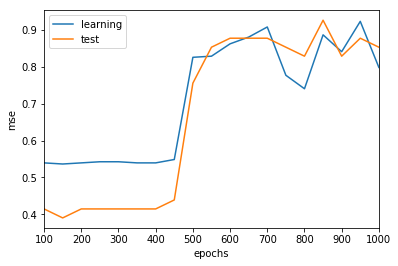

In [80]:
def evaluate_model_reg(model, X, y, X_test, y_test, epochs = None):
    
    if epochs is None:
        epochs = list(range(50, 501, 50))
        
    mse_scores_learn = []
    mse_scores_test = []
    
    for current_epochs in epochs:
        model.epochs = current_epochs
        model.fit(X, y)
        
        #learn
        y_pred = model.predict(X)
        m = mean_squared_error(y, y_pred)
        mse_scores_learn.append(m)
        
        #test
        y_pred = model.predict(X_test)      
        m = mean_squared_error(y_test, y_pred)
        mse_scores_test.append(m)

    return mse_scores_learn, mse_scores_test, epochs

model = MlpRegressor(hidden_layers=[(6, "sigmoid")], output_layer_activation= "sigmoid", momentum = 0.01,
                     epochs = 1000, learning_rate = 0.1, adaptative_learning_rate = (0.01, 0.05))

mse_scores_learn, mse_scores_test, epochs = evaluate_model_reg(model,Xt_learning.values, yt_learning.values, 
                                                     Xt_test.values, yt_test.values,list(range(100, 1001, 50)))


mse_data = pd.DataFrame({'learning' : mse_scores_learn, 'test': mse_scores_test}, index=epochs)
ax = acc_data.plot()
ax.set_ylabel("mse")
ax.set_xlabel("epochs")
plt.show()

700 epocas parece ser la mejor opción, luego se observa overfitting.

In [82]:

Xt_final = pd.concat([Xt_learning, Xt_test])
yt_final = pd.concat([yt_learning, yt_test])

final_model = MlpRegressor(hidden_layers=[(6, "sigmoid")], output_layer_activation= "sigmoid", momentum = 0.01,
                     epochs = 700, learning_rate = 0.1, adaptative_learning_rate = (0.01, 0.05))

Xt_final_np = Xt_final.values
yt_final_np = yt_final.values
Xt_val_np = Xt_val.values
yt_val_np = yt_val.values

final_model.fit(Xt_final_np, yt_final_np)
y_pred = final_model.predict(X_val_np)

display("mse: %s" % mean_squared_error(yt_val_np, y_pred))



'mse: 0.21870127531175654'